<a href="https://colab.research.google.com/github/tingtingting118/mm894_facemask_detection/blob/main/scripts/Yolov5_end2end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Setup environment



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pathname = '/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/'

In [ ]:
%cd $pathname

/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end


In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
%cd yolov5
%pip install -qr requirements.txt  # install dependencies (ignore errors)

/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5
     |████████████████████████████████| 596 kB 5.3 MB/s 


In [ ]:
# # install dependencies as necessary

# # !pip install gdrivedownload
# import torch
# from yolov5 import utils
# display = utils.notebook_init()  # checks

# #from IPython.display import Image, clear_output  # to display images
# #from utils.google_utils import gdrive_download  # to download models/datasets

# # clear_output()
# #print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [ ]:
 !pip install ruamel_yaml

     |████████████████████████████████| 109 kB 5.1 MB/s 
     |████████████████████████████████| 546 kB 29.7 MB/s 


In [ ]:
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET # to open xml files
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import re
import yaml
import sys
import ruamel.yaml



In [ ]:
#clone github picture to access picture for training
%cd $pathname
!git clone https://github.com/tingtingting118/mm894_facemask_detection.git

/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end
fatal: destination path 'mm894_facemask_detection' already exists and is not an empty directory.


In [ ]:
# A screenshot for project structure in github

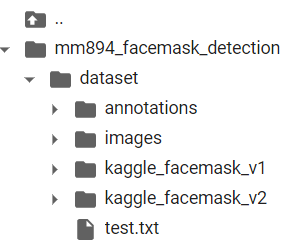

Example of current annotation format .xml

In [ ]:
!cat $pathname'mm894_facemask_detection/dataset/annotations/maksssksksss0.xml'

Need to change it to Yolov5 format for the annotations

In [ ]:
# Function to get the data from XML Annotation
def get_anno_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
          info_dict['filename'] = elem.text

            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
get_anno_from_xml("mm894_facemask_detection/dataset/annotations/maksssksksss136.xml")

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"mask_weared_incorrect": 0,
                           "with_mask": 1,
                           "without_mask": 2
                        }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    if  info_dict["filename"][-3:] == "png":
      #print(info_dict["filename"])
      save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
      #print(save_file_name)
    else:
      #print(info_dict["filename"])
      save_file_name = os.path.join("annotations", info_dict["filename"][:-3] + "txt")
      #print(save_file_name)
    # Save the annotation to disk
    #print(print_buffer)
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
%cd mm894_facemask_detection/dataset
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
  #print(ann)
  info_dict = get_anno_from_xml(ann)
  
  convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

In [ ]:
annotations[:10]

#test the annotaion by plotting an example chart (optional)

# change the dataset to 2 classes instead of 3 classes



*   class 1: with_mask
*   class 0: without_mask




change "wearing incorrectly" to "with_mask" for simplicity

In [ ]:
%cd $pathname{'mm894_facemask_detection'}

/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection


In [ ]:
file_list = os.listdir(f'./dataset/annotations')
for file in file_list:
  if not file.endswith('.txt'):
    continue
  with open(f'./dataset/annotations/{file}','r+') as f:
    lines = f.read()
    replaced = re.sub(r'0(?=\s\d+\.\d+){4}', '1', lines)
    replaced = re.sub(r'2(?=\s\d+\.\d+){4}', '0', lines)
    f.seek(0)
    f.write(replaced)
    f.truncate()

    

##Split the dataset into train, validation and test


In [ ]:
#read images and annotations
image = [os.path.join('images',x) for x in os.listdir('./dataset/images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('./dataset/annotations') if x[-3:] == "txt"]

#sort the names 
image.sort()
annotations.sort()

#split the dataset train 70% , validation 15% and test 15%
train_images, val_images, train_annotations, val_annotations = train_test_split(image,annotations,test_size = 0.3,random_state = 123 )
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 123)

In [ ]:
#create folders for train, validate and test within the path
!mkdir dataset/images/train dataset/images/val dataset/images/test dataset/annotations/train dataset/annotations/val dataset/annotations/test

In [ ]:
#move the files into different folders 
all_images = [train_images, val_images, test_images]
images_path = ['images/train','images/val', 'images/test']
all_annotations = [train_annotations, val_annotations, test_annotations]
annotations_path = ['annotations/train','annotations/val', 'annotations/test']





In [ ]:
%cd $pathname{'mm894_facemask_detection/dataset'}

for i, item_list in enumerate(all_images):
  for item in item_list:
    shutil.move(item, images_path[i])

for i, item_list in enumerate(all_annotations):
  for item in item_list:
    shutil.move(item, annotations_path[i])

In [ ]:
#rename annotations to labels since Yolov5 expect this name for your annotations data
!mv annotations labels

#Train on dataset of Kaggle


####Before you train the model, make sure you've change the yolov5s.yaml file under yolov5/models/yolov5s.yaml 

####change "nc : 2" which means you have 2 classes in your dataset for training.


In [ ]:
#reset path to yolov5
%cd $pathname{'yolov5'}


/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5


In [ ]:
yaml = ruamel.yaml.YAML()
yaml.preserve_quotes = True
with open('models/yolov5s.yaml') as fp:
     data = yaml.load(fp)
for elem in data:
  if elem == 'nc':
    data[elem] = 2
    break

with open('models/yolov5s.yaml', 'w') as outfile:
  #outfile.
  yaml.dump(data, outfile)


In [ ]:
## Train Model

!python train.py --freeze 3 --img 640 --batch 64 --epochs 100 \
--data $pathname'mm894_facemask_detection/dataset/data.yaml' \
--cfg $pathname'yolov5/models/yolov5s.yaml' \
--weights yolov5s.pt \
--name yolov5s_3f_100e_64b

train: weights=yolov5s.pt, cfg=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=12, imgsz=2560, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_3f_100e_12b_2560i, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[3], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 11 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-54-ga2d617e torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf

In [ ]:
## Tune Model Hyperparameters / Evolve

!python train.py --freeze 3 --img 640 --batch 64 --epochs 30 \
--evolve 100 \
--data $pathname'mm894_facemask_detection/dataset/data.yaml' \
--cfg $pathname'yolov5/models/yolov5s.yaml' \
--weights yolov5s.pt \
--name yolov5s_3f_100evo

Streaming output truncated to the last 5000 lines.
freezing model.2.cv3.bn.weight
freezing model.2.cv3.bn.bias
freezing model.2.m.0.cv1.conv.weight
freezing model.2.m.0.cv1.bn.weight
freezing model.2.m.0.cv1.bn.bias
freezing model.2.m.0.cv2.conv.weight
freezing model.2.m.0.cv2.bn.weight
freezing model.2.m.0.cv2.bn.bias
Scaled weight_decay = 0.00035
optimizer: SGD with parameter groups 57 weight (no decay), 60 weight, 60 bias
albumentations: version 1.0.3 required by YOLOv5, but version 0.1.12 is currently installed
train: Scanning '/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/../mm894_facemask_detection/dataset/labels/train.cache' images and labels... 631 found, 0 missing, 0 empty, 0 corrupt: 100% 631/631 [00:00<?, ?it/s]
val: Scanning '/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/../mm894_facemask_detection/dataset/labels/val.cache' images and labels... 135 found, 0 missing, 1 empty, 0 corrupt: 100% 135/135 [00:00<?, ?it/s]

AutoAnchor: 1.88 anchors

In [ ]:
## Train model on best tuned hyperparameters

!python train.py --freeze 3 --img 640 --batch 64 --epochs 100 \
--data $pathname'mm894_facemask_detection/dataset/data.yaml' \
--cfg $pathname'yolov5/models/yolov5s.yaml' \
--weights yolov5s.pt \
--name yolov5s_3f_100e_evolved \
--hyp $pathname'/yolov5/runs/evolve/yolov5s_3f_100evo/hyp_evolve.yaml'

train: weights=yolov5s.pt, cfg=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection/dataset/data.yaml, hyp=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end//yolov5/runs/evolve/yolov5s_3f_100evo/hyp_evolve.yaml, epochs=100, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_3f_100e_evolved, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[3], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
YOLOv5 🚀 v6.1-54-ga2d617e torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB

##Check performance from the model

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir runs
#mAP@[.5:.95](someone denoted mAP@[.5,.95]) 
#means average mAP over different IoU thresholds, from 0.5 to 0.95, step 0.05 (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95).

# Testing Now


In [ ]:
#path for pretrained weight model, could change to the right path you r looking for
test_dir = pathname+'mm894_facemask_detection/dataset/images/test'
val_dir = pathname+'mm894_facemask_detection/dataset/images/val'
weights_dir = pathname+'yolov5/runs/train/yolov5s_3f_100e_evolved/weights/best.pt'
data_dir = pathname+'mm894_facemask_detection/dataset/data.yaml'

test_dir2 = pathname+'mm894_facemask_detection/dataset/video1.mp4'

In [ ]:
%cd $pathname{'yolov5'}

/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5


In [ ]:
!python detect.py --source $test_dir --weights $weights_dir --imgsz 640

detect: weights=['/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/runs/train/yolov5s_3f_100e_evolved/weights/best.pt'], source=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection/dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-54-ga2d617e torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/136 /content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection/dataset/images/test/39_jpg.rf.419f607b8ce1a2932992d1c8f66d38da.jpg: 448x640 8 No Masks, Done. (0.011s)
ima

In [ ]:
#val/test data performance 
!python val.py --data $data_dir --weights $weights_dir --img 640

val: data=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection/dataset/data.yaml, weights=['/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/runs/train/yolov5s_3f_100e_evolved/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-54-ga2d617e torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/../mm894_facemask_detection/dataset/labels/val.cache' images and labels... 135 found, 0 missing, 1 empty, 0 corrupt: 100% 135/135 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:   

In [ ]:
!python val.py --data $data_dir --weights $weights_dir --img 640 --task test

val: data=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection/dataset/data.yaml, weights=['/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/runs/train/yolov5s_3f_100e_evolved/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-54-ga2d617e torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/../mm894_facemask_detection/dataset/labels/test.cache' images and labels... 136 found, 0 missing, 0 empty, 0 corrupt: 100% 136/136 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:

In [ ]:
!python detect.py --source $test_dir2 --weights $weights_dir --imgsz 3200

detect: weights=['/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/yolov5/runs/train/yolov5s_3f_100e_evolved/weights/best.pt'], source=/content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection/dataset/video1.mp4, data=data/coco128.yaml, imgsz=[3200, 3200], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-54-ga2d617e torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/1525) /content/drive/MyDrive/MMAI/MMAI894_TeamProject/end2end/mm894_facemask_detection/dataset/video1.mp4: 1824x3200 1 No Mask, 3 With Masks, Done. (0.050s)
video 1/1 (2/1525) /content/